# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

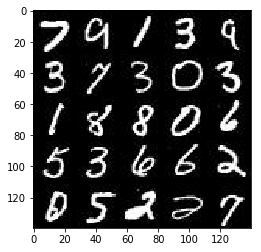

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

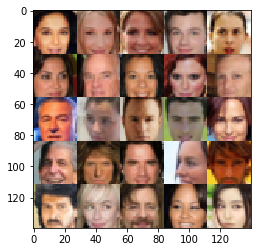

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layer is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding='same', 
                              kernel_initializer= tf.random_normal_initializer(stddev = 0.02))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding= 'same',
                              kernel_initializer = tf.random_normal_initializer(stddev= 0.02))
        bn2 = tf.layers.batch_normalization(x2, training= True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides= 2, padding= 'same',
                              kernel_initializer = tf.random_normal_initializer(stddev= 0.02))
        bn3 = tf.layers.batch_normalization(x3, training= True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer= tf.random_normal_initializer(stddev = 0.02))
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement 
    alpha = 0.2
    with tf.variable_scope('generator', reuse = False if is_train == True else True):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256, kernel_initializer= tf.random_normal_initializer(stddev= 0.02))
        # Reshape it to start the convolution stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training= is_train)
        relu1 = tf.nn.relu(bn1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides = 2, padding= 'same',
                                        kernel_initializer = tf.random_normal_initializer(stddev= 0.02))
        bn2 = tf.layers.batch_normalization(x2, training= is_train)
        relu2 = tf.nn.relu(bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides= 2, padding= 'same',
                                        kernel_initializer = tf.random_normal_initializer(stddev = 0.02))
        bn3 = tf.layers.batch_normalization(x3, training= is_train)
        relu3 = tf.nn.relu(bn3)
        # 28x28x64
        
        #Output Layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding= 'same',
                                            kernel_initializer = tf.random_normal_initializer(stddev= 0.02))
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim, is_train= True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse= True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_real, 
                                                                         labels= tf.ones_like(d_logits_real) * smooth))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                         labels = tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                    labels = tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate= learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate= learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 50
    show_every = 200
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Shaping and re-scaling the batch images...[Forum Suggestion!]
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                # Sample Noise for G
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run Optimizers (run generator more often than discriminator... [Forum Suggestion!])
                _ = sess.run(d_opt, feed_dict = {inputs_real : batch_images, inputs_z : batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {inputs_real : batch_images, inputs_z : batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {inputs_real : batch_images, inputs_z : batch_z, lr: learning_rate})
                
                # Get the losses and print them out for every n steps
                if steps%print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict = {inputs_real : batch_images, inputs_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval(feed_dict = {inputs_real : batch_images, inputs_z: batch_z, lr: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # Show Generator output every 100 steps
                if steps%show_every == 0:
                    show_generator_output(sess, 30, inputs_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 50... Discriminator Loss: 1.4915... Generator Loss: 0.6553
Epoch 1/2... Step 100... Discriminator Loss: 1.7067... Generator Loss: 1.4089
Epoch 1/2... Step 150... Discriminator Loss: 1.3916... Generator Loss: 0.5541
Epoch 1/2... Step 200... Discriminator Loss: 1.3823... Generator Loss: 0.5139


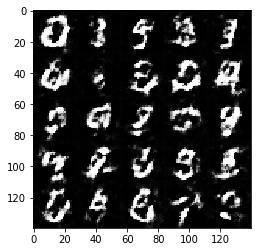

Epoch 1/2... Step 250... Discriminator Loss: 1.4200... Generator Loss: 0.5244
Epoch 1/2... Step 300... Discriminator Loss: 1.4348... Generator Loss: 0.8139
Epoch 1/2... Step 350... Discriminator Loss: 1.5158... Generator Loss: 0.4429
Epoch 1/2... Step 400... Discriminator Loss: 1.5396... Generator Loss: 0.4386


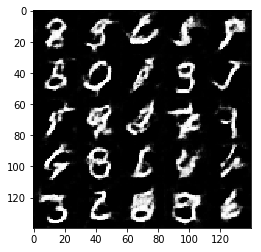

Epoch 1/2... Step 450... Discriminator Loss: 1.4064... Generator Loss: 0.5764
Epoch 1/2... Step 500... Discriminator Loss: 1.3637... Generator Loss: 0.7833
Epoch 1/2... Step 550... Discriminator Loss: 1.4993... Generator Loss: 0.4936
Epoch 1/2... Step 600... Discriminator Loss: 1.3597... Generator Loss: 0.6185


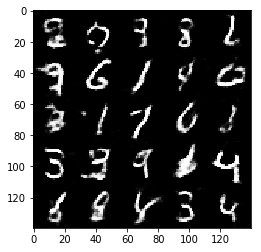

Epoch 1/2... Step 650... Discriminator Loss: 1.4207... Generator Loss: 0.5929
Epoch 1/2... Step 700... Discriminator Loss: 1.3861... Generator Loss: 0.8730
Epoch 1/2... Step 750... Discriminator Loss: 1.2525... Generator Loss: 0.8158
Epoch 1/2... Step 800... Discriminator Loss: 1.3857... Generator Loss: 0.8798


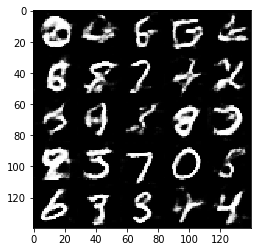

Epoch 1/2... Step 850... Discriminator Loss: 1.4183... Generator Loss: 1.0940
Epoch 1/2... Step 900... Discriminator Loss: 1.5402... Generator Loss: 0.4369
Epoch 2/2... Step 950... Discriminator Loss: 1.3131... Generator Loss: 0.8841
Epoch 2/2... Step 1000... Discriminator Loss: 1.5610... Generator Loss: 0.4650


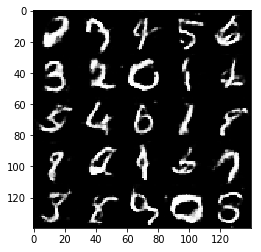

Epoch 2/2... Step 1050... Discriminator Loss: 1.4937... Generator Loss: 0.5397
Epoch 2/2... Step 1100... Discriminator Loss: 1.4189... Generator Loss: 0.5416
Epoch 2/2... Step 1150... Discriminator Loss: 1.7482... Generator Loss: 0.3369
Epoch 2/2... Step 1200... Discriminator Loss: 1.3202... Generator Loss: 0.8556


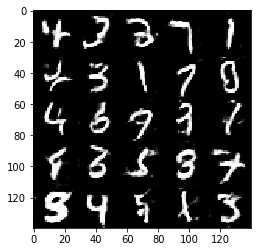

Epoch 2/2... Step 1250... Discriminator Loss: 1.4057... Generator Loss: 0.6208
Epoch 2/2... Step 1300... Discriminator Loss: 1.2851... Generator Loss: 0.6965
Epoch 2/2... Step 1350... Discriminator Loss: 1.2683... Generator Loss: 0.9546
Epoch 2/2... Step 1400... Discriminator Loss: 1.5375... Generator Loss: 0.4593


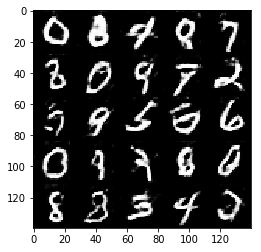

Epoch 2/2... Step 1450... Discriminator Loss: 1.5991... Generator Loss: 0.4049
Epoch 2/2... Step 1500... Discriminator Loss: 1.4223... Generator Loss: 0.5308
Epoch 2/2... Step 1550... Discriminator Loss: 1.3269... Generator Loss: 0.9577
Epoch 2/2... Step 1600... Discriminator Loss: 1.5155... Generator Loss: 0.4556


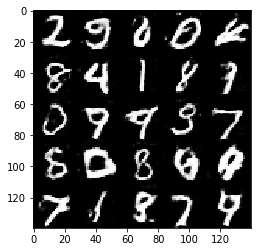

Epoch 2/2... Step 1650... Discriminator Loss: 1.3877... Generator Loss: 0.5600
Epoch 2/2... Step 1700... Discriminator Loss: 1.2007... Generator Loss: 0.9424
Epoch 2/2... Step 1750... Discriminator Loss: 1.3466... Generator Loss: 0.6843
Epoch 2/2... Step 1800... Discriminator Loss: 1.2725... Generator Loss: 0.6841


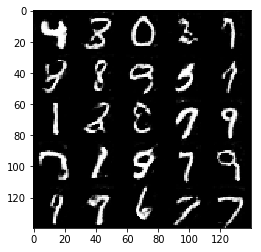

Epoch 2/2... Step 1850... Discriminator Loss: 1.3875... Generator Loss: 0.5258


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Step 50... Discriminator Loss: 1.0100... Generator Loss: 1.0305
Epoch 1/2... Step 100... Discriminator Loss: 1.4055... Generator Loss: 0.7694
Epoch 1/2... Step 150... Discriminator Loss: 1.2534... Generator Loss: 0.8896
Epoch 1/2... Step 200... Discriminator Loss: 1.3979... Generator Loss: 0.6592


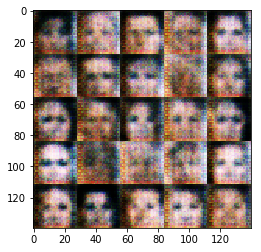

Epoch 1/2... Step 250... Discriminator Loss: 1.2606... Generator Loss: 0.8227
Epoch 1/2... Step 300... Discriminator Loss: 1.2441... Generator Loss: 0.7365
Epoch 1/2... Step 350... Discriminator Loss: 1.3696... Generator Loss: 0.6265
Epoch 1/2... Step 400... Discriminator Loss: 1.3738... Generator Loss: 0.8524


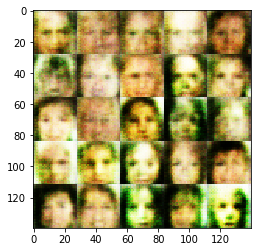

Epoch 1/2... Step 450... Discriminator Loss: 1.4873... Generator Loss: 0.7691
Epoch 1/2... Step 500... Discriminator Loss: 1.3639... Generator Loss: 0.8809
Epoch 1/2... Step 550... Discriminator Loss: 1.4674... Generator Loss: 0.6957
Epoch 1/2... Step 600... Discriminator Loss: 1.3965... Generator Loss: 0.7751


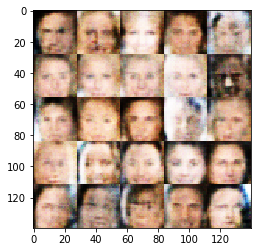

Epoch 1/2... Step 650... Discriminator Loss: 1.4807... Generator Loss: 0.7509
Epoch 1/2... Step 700... Discriminator Loss: 1.4750... Generator Loss: 0.6962
Epoch 1/2... Step 750... Discriminator Loss: 1.3397... Generator Loss: 0.7718
Epoch 1/2... Step 800... Discriminator Loss: 1.3139... Generator Loss: 0.7329


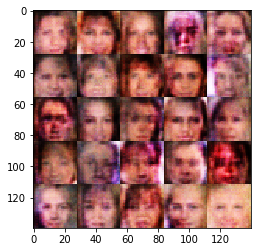

Epoch 1/2... Step 850... Discriminator Loss: 1.2120... Generator Loss: 0.8592
Epoch 1/2... Step 900... Discriminator Loss: 1.2520... Generator Loss: 0.9070
Epoch 1/2... Step 950... Discriminator Loss: 1.4706... Generator Loss: 0.7243
Epoch 1/2... Step 1000... Discriminator Loss: 1.4211... Generator Loss: 0.7176


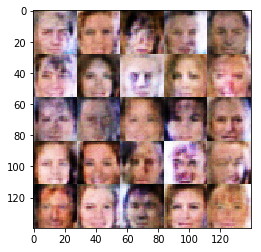

Epoch 1/2... Step 1050... Discriminator Loss: 1.3576... Generator Loss: 0.8042
Epoch 1/2... Step 1100... Discriminator Loss: 1.4092... Generator Loss: 0.7637
Epoch 1/2... Step 1150... Discriminator Loss: 1.3375... Generator Loss: 0.8349
Epoch 1/2... Step 1200... Discriminator Loss: 1.3837... Generator Loss: 0.9055


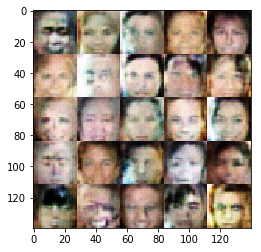

Epoch 1/2... Step 1250... Discriminator Loss: 1.4142... Generator Loss: 0.8589
Epoch 1/2... Step 1300... Discriminator Loss: 1.3526... Generator Loss: 0.7714
Epoch 1/2... Step 1350... Discriminator Loss: 1.3866... Generator Loss: 0.6696
Epoch 1/2... Step 1400... Discriminator Loss: 1.2806... Generator Loss: 0.8385


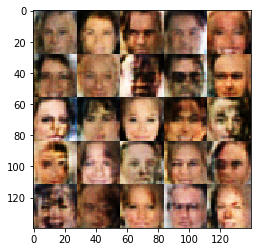

Epoch 1/2... Step 1450... Discriminator Loss: 1.3505... Generator Loss: 0.7097
Epoch 1/2... Step 1500... Discriminator Loss: 1.3949... Generator Loss: 0.6928
Epoch 1/2... Step 1550... Discriminator Loss: 1.6151... Generator Loss: 0.5316
Epoch 1/2... Step 1600... Discriminator Loss: 1.4580... Generator Loss: 0.7374


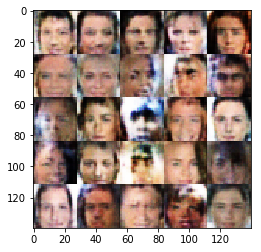

Epoch 1/2... Step 1650... Discriminator Loss: 1.3868... Generator Loss: 0.8162
Epoch 1/2... Step 1700... Discriminator Loss: 1.4327... Generator Loss: 0.7380
Epoch 1/2... Step 1750... Discriminator Loss: 1.3986... Generator Loss: 0.7629
Epoch 1/2... Step 1800... Discriminator Loss: 1.2535... Generator Loss: 0.8576


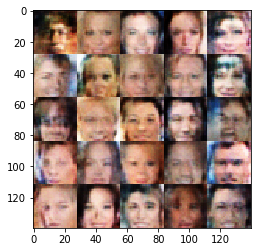

Epoch 1/2... Step 1850... Discriminator Loss: 1.4073... Generator Loss: 0.7860
Epoch 1/2... Step 1900... Discriminator Loss: 1.3358... Generator Loss: 0.7713
Epoch 1/2... Step 1950... Discriminator Loss: 1.3236... Generator Loss: 0.8069
Epoch 1/2... Step 2000... Discriminator Loss: 1.3783... Generator Loss: 0.7609


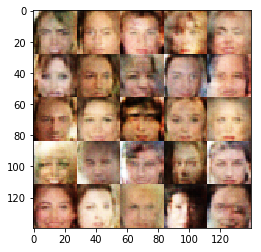

Epoch 1/2... Step 2050... Discriminator Loss: 1.4225... Generator Loss: 0.6859
Epoch 1/2... Step 2100... Discriminator Loss: 1.3327... Generator Loss: 0.8561
Epoch 1/2... Step 2150... Discriminator Loss: 1.3198... Generator Loss: 0.8479
Epoch 1/2... Step 2200... Discriminator Loss: 1.4865... Generator Loss: 0.5622


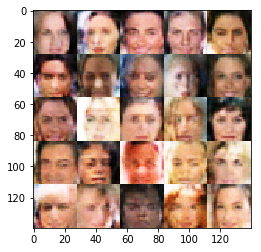

Epoch 1/2... Step 2250... Discriminator Loss: 1.4448... Generator Loss: 0.6507
Epoch 1/2... Step 2300... Discriminator Loss: 1.4391... Generator Loss: 0.6726
Epoch 1/2... Step 2350... Discriminator Loss: 1.3671... Generator Loss: 0.7653
Epoch 1/2... Step 2400... Discriminator Loss: 1.3327... Generator Loss: 0.8412


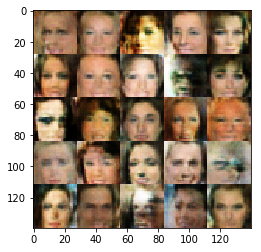

Epoch 1/2... Step 2450... Discriminator Loss: 1.4480... Generator Loss: 0.6855
Epoch 1/2... Step 2500... Discriminator Loss: 1.4535... Generator Loss: 0.6947
Epoch 1/2... Step 2550... Discriminator Loss: 1.5280... Generator Loss: 0.6229
Epoch 1/2... Step 2600... Discriminator Loss: 1.3594... Generator Loss: 0.7874


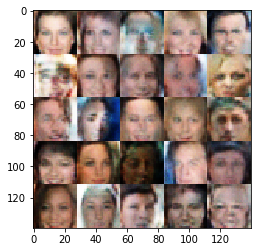

Epoch 1/2... Step 2650... Discriminator Loss: 1.3568... Generator Loss: 0.8155
Epoch 1/2... Step 2700... Discriminator Loss: 1.4465... Generator Loss: 0.7780
Epoch 1/2... Step 2750... Discriminator Loss: 1.3543... Generator Loss: 0.7195
Epoch 1/2... Step 2800... Discriminator Loss: 1.3755... Generator Loss: 0.7847


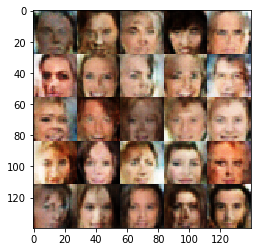

Epoch 1/2... Step 2850... Discriminator Loss: 1.4467... Generator Loss: 0.7316
Epoch 1/2... Step 2900... Discriminator Loss: 1.3703... Generator Loss: 0.7612
Epoch 1/2... Step 2950... Discriminator Loss: 1.3924... Generator Loss: 0.7687
Epoch 1/2... Step 3000... Discriminator Loss: 1.4546... Generator Loss: 0.6558


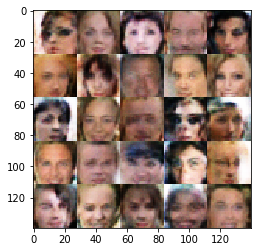

Epoch 1/2... Step 3050... Discriminator Loss: 1.4326... Generator Loss: 0.7042
Epoch 1/2... Step 3100... Discriminator Loss: 1.4233... Generator Loss: 0.6928
Epoch 1/2... Step 3150... Discriminator Loss: 1.3396... Generator Loss: 0.7641
Epoch 2/2... Step 3200... Discriminator Loss: 1.3740... Generator Loss: 0.7159


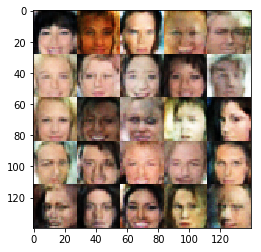

Epoch 2/2... Step 3250... Discriminator Loss: 1.4498... Generator Loss: 0.6470
Epoch 2/2... Step 3300... Discriminator Loss: 1.4180... Generator Loss: 0.6757
Epoch 2/2... Step 3350... Discriminator Loss: 1.3807... Generator Loss: 0.7992
Epoch 2/2... Step 3400... Discriminator Loss: 1.4367... Generator Loss: 0.7170


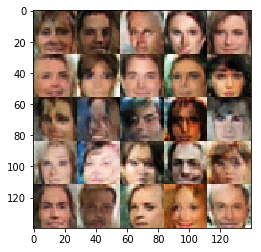

Epoch 2/2... Step 3450... Discriminator Loss: 1.3888... Generator Loss: 0.8220
Epoch 2/2... Step 3500... Discriminator Loss: 1.3385... Generator Loss: 0.7892
Epoch 2/2... Step 3550... Discriminator Loss: 1.5228... Generator Loss: 0.6145
Epoch 2/2... Step 3600... Discriminator Loss: 1.3929... Generator Loss: 0.7134


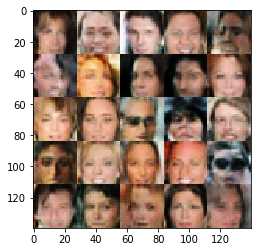

Epoch 2/2... Step 3650... Discriminator Loss: 1.3917... Generator Loss: 0.6642
Epoch 2/2... Step 3700... Discriminator Loss: 1.3972... Generator Loss: 0.7310
Epoch 2/2... Step 3750... Discriminator Loss: 1.4650... Generator Loss: 0.6468
Epoch 2/2... Step 3800... Discriminator Loss: 1.5392... Generator Loss: 0.7123


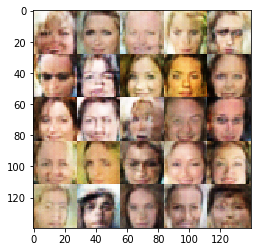

Epoch 2/2... Step 3850... Discriminator Loss: 1.3434... Generator Loss: 0.7603
Epoch 2/2... Step 3900... Discriminator Loss: 1.4388... Generator Loss: 0.7747
Epoch 2/2... Step 3950... Discriminator Loss: 1.3542... Generator Loss: 0.8142
Epoch 2/2... Step 4000... Discriminator Loss: 1.3990... Generator Loss: 0.6631


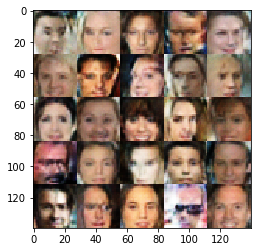

Epoch 2/2... Step 4050... Discriminator Loss: 1.3937... Generator Loss: 0.7622
Epoch 2/2... Step 4100... Discriminator Loss: 1.4538... Generator Loss: 0.7131
Epoch 2/2... Step 4150... Discriminator Loss: 1.3828... Generator Loss: 0.7170
Epoch 2/2... Step 4200... Discriminator Loss: 1.4241... Generator Loss: 0.6738


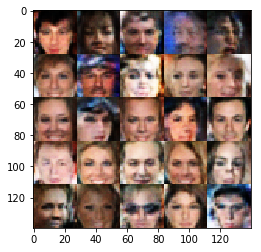

Epoch 2/2... Step 4250... Discriminator Loss: 1.2550... Generator Loss: 0.8097
Epoch 2/2... Step 4300... Discriminator Loss: 1.3551... Generator Loss: 0.7266
Epoch 2/2... Step 4350... Discriminator Loss: 1.2655... Generator Loss: 0.7709
Epoch 2/2... Step 4400... Discriminator Loss: 1.4506... Generator Loss: 0.6387


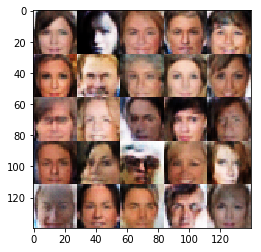

Epoch 2/2... Step 4450... Discriminator Loss: 1.5397... Generator Loss: 0.6751
Epoch 2/2... Step 4500... Discriminator Loss: 1.4580... Generator Loss: 0.6191
Epoch 2/2... Step 4550... Discriminator Loss: 1.4283... Generator Loss: 0.7661
Epoch 2/2... Step 4600... Discriminator Loss: 1.3722... Generator Loss: 0.7755


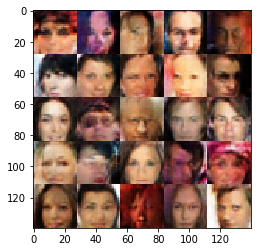

Epoch 2/2... Step 4650... Discriminator Loss: 1.3845... Generator Loss: 0.7219
Epoch 2/2... Step 4700... Discriminator Loss: 1.3299... Generator Loss: 0.7701
Epoch 2/2... Step 4750... Discriminator Loss: 1.3626... Generator Loss: 0.7339
Epoch 2/2... Step 4800... Discriminator Loss: 1.3837... Generator Loss: 0.7583


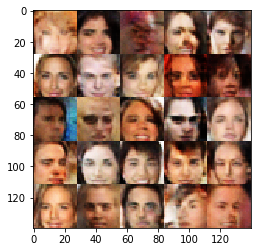

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

## Notes to the reviewer!

I already applied some external suggestions which i got to know from sources like stack and Udacity Forums to level up the quality a bit. 
The suggestions which i worked on were:

1) kernel initializer with stddev = 0.02

2) rescaling and shaping the batch_images

3) Running the generator optimizer more than discriminator optimizer.

4) Setting num of epochs to 2.

Also, the second epoch has not been completed since the floydhub new update has a one hour timeout for unpaid members. So the second epoch was left halfway.

Do let me know if i need to add or remove some of them or need to implement it more correctly.


### Thank You!